In [1]:

import os
import numpy as np
import struct
from PIL import Image
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms as tfs
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt
import datetime;
'''
判断一个文件夹是否存在：
from pathlib import Path
dir=Path(string path)
dir.exists()
'''
from pathlib import Path

In [2]:

#下面的路径根据个人改变；
#从网站上下载下来的三个压缩包：两个为训练集合，一个为测试集合；
#两个训练集合解压到/root/autodl-tmp/train目录下；测试集合解压到/root/autodl-tmp/test目录下；
#三个压缩包解压只有得到的是.gnt文件，需要转化成.png图像文件；
#所有的用于训练的图像在/root/autodl-tmp/data/train目录下；用于测试的图像文件在/root/autodl-tmp/data/test目录下；
#下面程序：将解压得到的.gnt文件转换成.png文件，并且将数据按照类别分别存放在不同的子目录中；
data_dir = '/root/autodl-tmp/'
train_data_dir = os.path.join(data_dir, 'train')
test_data_dir = os.path.join(data_dir, 'test')
def read_from_gnt_dir(gnt_dir=train_data_dir):
    def one_file(f):
        header_size = 10
        while True:
            header = np.fromfile(f, dtype='uint8', count=header_size)
            if not header.size: break
            sample_size = header[0] + (header[1]<<8) + (header[2]<<16) + (header[3]<<24)
            tagcode = header[5] + (header[4]<<8)
            width = header[6] + (header[7]<<8)
            height = header[8] + (header[9]<<8)
            if header_size + width*height != sample_size:
                break
            image = np.fromfile(f, dtype='uint8', count=width*height).reshape((height, width))
            yield image, tagcode
    for file_name in os.listdir(gnt_dir):
        if file_name.endswith('.gnt'):
            file_path = os.path.join(gnt_dir, file_name)
            with open(file_path, 'rb') as f:
                for image, tagcode in one_file(f):
                    yield image, tagcode

char_set = set()
for _, tagcode in read_from_gnt_dir(gnt_dir=train_data_dir):
    tagcode_unicode = struct.pack('>H', tagcode).decode('gb18030')
    char_set.add(tagcode_unicode)
char_list = list(char_set)
char_dict = dict(zip(sorted(char_list), range(len(char_list))))
print(len(char_dict))#输出类别总数；
import pickle
f = open('char_dict', 'wb')
pickle.dump(char_dict, f)
f.close()
train_counter = 0
test_counter = 0
for image, tagcode in read_from_gnt_dir(gnt_dir=train_data_dir):
    tagcode_unicode = struct.pack('>H', tagcode).decode('gb18030')
    im = Image.fromarray(image)
    dir_name ='/root/autodl-tmp/data/train/' + '%0.5d'%char_dict[tagcode_unicode]
    if not os.path.exists(os.path.join(dir_name)):
        os.mkdir(os.path.join(dir_name))
    im.convert('RGB').save(os.path.join(dir_name)+'/' + str(train_counter) + '.png')
    train_counter += 1
print("finish train set")
for image, tagcode in read_from_gnt_dir(gnt_dir=test_data_dir):
    tagcode_unicode = struct.pack('>H', tagcode).decode('gb18030')
    im = Image.fromarray(image)
    dir_name = '/root/autodl-tmp/data/test/' + '%0.5d'%char_dict[tagcode_unicode]
    if not os.path.exists(os.path.join(dir_name)):
        os.mkdir(os.path.join(dir_name))
    im.convert('RGB').save(os.path.join(dir_name)+'/' + str(test_counter) + '.png')
    test_counter += 1
print("finish all")

3926
finish train
finish all


In [2]:
import logging
#生成日志文件；
def get_logger(filename, verbosity=1, name=None):
    level_dict = {0: logging.DEBUG, 1: logging.INFO, 2: logging.WARNING}
    formatter = logging.Formatter(
        "[%(asctime)s][%(filename)s][line:%(lineno)d][%(levelname)s] %(message)s"
    )
    logger = logging.getLogger(name)
    logger.setLevel(level_dict[verbosity])

    fh = logging.FileHandler(filename, "w")
    fh.setFormatter(formatter)
    logger.addHandler(fh)

    sh = logging.StreamHandler()
    sh.setFormatter(formatter)
    logger.addHandler(sh)

    return logger

In [3]:
now = datetime.datetime.now() # 获得当前时间来给日志文件命名；
timestr = now.strftime("%Y_%m_%d_%H_%M_%S")
print('年_月_日_时_分_秒：', timestr)
dir = os.getcwd() + '/traininglog_' + timestr 

年_月_日_时_分_秒： 2022_12_10_10_52_21


## 数据预处理；

In [4]:
'''
训练和测试过程中的预处理过程是不同的：预测中不做训练过程的数据增强操作；
数据增强的操作应该在归一化和标准化之前；
预处理的过程：
1.将PIL.Image转化为灰度图像
2.调整尺寸:先通过填充将图像变成正方形，然后通过resize进行下采样或者上采样；
3.旋转一定的角度8度内的随机旋转
4.亮度和对比度的随机变化;
5.归一化；
6.标准化和中心化
返回的是张量
'''
def train_preprocess(x):
    x=x.convert('L')
    '''
    这里的x是PIL.Image形式的数据，没有shape数据成员，但是访问图像的尺寸可以使用size数据成员
    size的形式是(宽度，高度)
    即使读取到的是三通道的图像，size中不会有通道数；
    将PIL.image转化为numpy或者tensor类型的数据，图像的高度一般都在图像的宽度的前面；
        eg:彩色图像的numpy矩阵的尺寸：(高度，宽度，通道数)
    '''
    padding=();#当padding表示四元组的时候，四个元素依次表示左，上，右，下的边框的填充;
    if x.size[0]>x.size[1]:#对高度进行填充：
        temp=int((x.size[0]-x.size[1])/2)
        padding=(0,temp,0,x.size[0]-x.size[1]-temp)
    elif x.size[0]<x.size[1]:#对宽度进行填充；
        temp=int((x.size[1]-x.size[0])/2)
        padding=(temp,0,x.size[1]-x.size[0]-temp,0)
    if x.size[0]!=x.size[1]:#当输入图像的宽度和高度相等的时候，不进行填充；
        x=tfs.Pad(padding,fill=255,padding_mode='constant')(x);
    function=tfs.Compose([
        tfs.Resize(64),
        tfs.RandomRotation(8),#数据增强；
        tfs.ColorJitter(brightness=0.5,contrast=0.5),#数据增强；
        tfs.ToTensor(),
        tfs.Normalize(0.5,0.5)
    ])
    x=function(x)
    return x
def test_preprocess(x):#对测试数据的预处理中不进行数据增强；
    x=x.convert('L')
    padding=();
    if x.size[0]>x.size[1]:
        temp=int((x.size[0]-x.size[1])/2)
        padding=(0,temp,0,x.size[0]-x.size[1]-temp)
    elif x.size[0]<x.size[1]:
        temp=int((x.size[1]-x.size[0])/2)
        padding=(temp,0,x.size[1]-x.size[0]-temp,0)
    if x.size[0]!=x.size[1]:
        x=tfs.Pad(padding,fill=255,padding_mode='constant')(x);
    function=tfs.Compose([
        tfs.Resize(64),
        tfs.ToTensor(),
        tfs.Normalize(0.5,0.5)
    ])
    x=function(x)
    return x
#使用ImgaeFolder来获得数据集合；
train_set=ImageFolder("/root/autodl-tmp/data/train/",transform=train_preprocess)
test_set=ImageFolder("/root/autodl-tmp/data/test/",transform=test_preprocess)
#使用dataloader实现分批获取数据；
train_data=DataLoader(train_set,batch_size=64,shuffle=True)#训练数据通常需要打乱,测试数据通常不用；
test_data=DataLoader(test_set,batch_size=128,shuffle=False)

## 构建模型

In [12]:

def conv3x3(in_channel,out_channel,stride=1):#自定义的卷积模块，注意残差模块中的卷积层一般不适用偏置参数;
    return nn.Conv2d(in_channel,out_channel,3,stride=stride,padding=1,bias=False);
class resnet_block(nn.Module):#自定义的小的残差模块；
    def __init__(self,in_channel,out_channel,same_shape=True):
    #same_shape==True：表示这个模块输入和输出的尺寸是相同的，如果是False,表示输出的宽度和高度是输入的一半；
        super(resnet_block,self).__init__();
        self.Same_shape=same_shape;
        stride =1 if self.Same_shape else 2;
        self.conv1=conv3x3(in_channel,out_channel,stride=stride);
        self.bn1=nn.BatchNorm2d(out_channel)
        self.conv2=conv3x3(out_channel,out_channel);
        self.bn2=nn.BatchNorm2d(out_channel)
        if not self.Same_shape:
            self.conv3=nn.Conv2d(in_channel,out_channel,1,stride=stride);
    def forward(self,x):
        out=self.conv1(x)
        out=F.relu6(self.bn1(out),True);
        out=self.conv2(out);
        out=F.relu6(self.bn2(out),True);
        if not self.Same_shape:
            x=self.conv3(x)
        return F.relu6(x+out,True);

class Resnet(nn.Module):
    def __init__(self,in_channel,num_classes,show=False):#总共有3926个类；
        super(Resnet,self).__init__()
        self.show=show;
        self.block1=nn.Sequential(#第一个部分：借鉴了VGG的网路结构；
            nn.Conv2d(in_channel,128,3,1,1),
            nn.BatchNorm2d(128),
            nn.ReLU6(True),
            nn.Conv2d(128,128,3,1,1),
            nn.BatchNorm2d(128),
            nn.ReLU6(True),
            nn.MaxPool2d(2,2),#(batch_size,128,32,32);
            nn.Conv2d(128,256,3,1,1),
            nn.BatchNorm2d(256),
            nn.ReLU6(True),
            nn.Conv2d(256,256,3,1,1),
            nn.BatchNorm2d(256),
            nn.ReLU6(True),
            nn.MaxPool2d(2,2),#此时图像的尺寸：(batch_size,256,16,16);
        )
        self.block2=nn.Sequential(#第二部分:使用残差网络进行堆叠；
            resnet_block(256,512,False),
            #resnet_block(512,512),#(512,8,8)设计的过程不要多层输出的channel保持不变,可能效果不好；！！！！
            resnet_block(512,1024,False),#(batch_size,1024,4,4)
            #resnet_block(1024,1024),
            nn.AvgPool2d(2)#(batch_size,1024,2,2）
        )
        self.FC_block=nn.Sequential(#第三部分：全连接层；
            nn.Dropout(0.5),#防止过拟合；
            nn.Linear(4096,3926)
        )
    def forward(self,x):
        out=self.block1(x)
        out=self.block2(out)
        out=out.view(out.shape[0],-1)
        if self.show:
            print(out.shape)
        out=self.FC_block(out)
        return out;
    
#测试网络模型是否能够正常处理输入数据；
test_net=Resnet(1,3926,True)
test_input=Variable(torch.zeros(2,1,64,64))#输入的数据的batch_size必须大于1，否则在网络模型的batchnormlize层会报错；
test_output=test_net(test_input)
print(test_output.shape)

torch.Size([2, 4096])
torch.Size([2, 3926])


In [13]:
#参数的初始化；
def weight_init(m):
    #print(m.__class__.__name__)
    if m.__class__.__name__.find("Conv")!=-1:#使用高斯分布来对卷积层的参数进行初始化；
        if m.bias!=None:
            m.bias.data.fill_(0.0)
        nn.init.normal_(m.weight.data,0.0,0.03)
    elif m.__class__.__name__.find("BatchNorm")!=-1:#batchnormlize层中也有权重参数；
        nn.init.normal_(m.weight.data,1.0,0.02)
        m.bias.data.fill_(0.0)
#使用学习率递减的优化器
net=Resnet(1,3926,False).cuda().apply(weight_init)
optimer=torch.optim.Adam(net.parameters(),lr=0.0001,weight_decay=1e-4)#weight_decay为防止过拟合；
#网络结构和学习率对学习结果的影响大于weight_decay等其他参数对结果的影响;
scheduler=LambdaLR(optimer,lr_lambda=lambda epoch: 1.0/(epoch+1))#使得训练过程中的学习率逐渐降低；
loss_function=nn.CrossEntropyLoss()#损失函数；

## 进行训练：

In [16]:
def train(net,train_data,test_data,iter_num,optimer,scheduler,lossfunction,is_request_accuracy=0):
'''
    net为网络模型；
    train_data和test_data分别为训练和测试的数据；
    iter_num:为设置的总训练轮数；
    optimer：为优化器
    scheduler:对优化器的学习率进行调整的对象
    lossfunction:是损失函数；
    is_request_accuracy:是否输出训练过程的信息，为0的时候输出；
'''
    losses=[]
    acces=[]
    eval_losses=[]
    eval_acces=[]#这四个列表是用来存储每一轮训练的过程中的参数，以便后面使用这些参数来绘制图像；
    logger = get_logger(dir)
    logger.info('start training!')
    temp=0;
    for epoch in range(iter_num):
        train_loss=0
        train_acc=0;
        #训练：
        net.train()
        for im,label in train_data:
            im=Variable(im).cuda();
            label=Variable(label).cuda()
            out=net(im);
            loss=lossfunction(out,label)
            optimer.zero_grad()
            loss.backward()
            optimer.step()
            train_loss+=loss.data;
            #计算准确率：每个批中的准确率，正确预测的数目除以该批次中样本的总数；
            prediction=out.max(1)[1]
            num_correct=(prediction==label).sum().data
            train_acc+=num_correct/im.shape[0];
        losses.append((train_loss/len(train_data)).data.cpu().numpy())
        acces.append((train_acc/len(train_data)).data.cpu().numpy())
        eval_loss=0;
        eval_acc=0;
        #测试；
        net.eval()
        for im,label in test_data:
            im=Variable(im).cuda()
            label=Variable(label).cuda()
            out=net(im)
            loss=lossfunction(out,label)
            eval_loss+=loss.data;
            prediction=out.max(1)[1];
            num_correct=(prediction==label).sum().data
            eval_acc+=num_correct/im.shape[0]
        eval_losses.append((eval_loss/len(test_data)).data.cpu().numpy())
        eval_acces.append((eval_acc/len(test_data)).data.cpu().numpy())
        train_loss_=(train_loss/len(train_data)).data.cpu().numpy()#训练集上损失；
        train_acc_=(train_acc/len(train_data)).data.cpu().numpy()#训练集上准确率；
        test_loss_=(eval_loss/len(test_data)).data.cpu().numpy()#测试集上损失；
        test_acc_=(eval_acc/len(test_data)).data.cpu().numpy()#测试集上准确率
        logger.info('Epoch:[{}]\t train_loss={:.8f}\t train_acc={:.8f}\t test_loss={:.8f}\t test_acc={:.8f}'.format(epoch , train_loss_,train_acc_,test_loss_, test_acc_))
        if is_request_accuracy==0:
            print("epoch:",epoch,"train_loss:",train_loss_,"train_acc:",train_acc_,"eval_loss:",test_loss_,"eval_acc:",test_acc_)
        else :
            if (eval_acc/len(test_data)).data.cpu().numpy()>=0.99:
                break;
        if test_acc_-temp<-0.008:#准确率下降过多的时候早停；
            break;
        temp=test_acc_;
        print("第%d个epoch的学习率：%f" % (epoch, optimer.param_groups[0]['lr']))
        scheduler.step()#改变下一轮训练中的学习率
            
    logger.info('finish training!')
    #绘制训练过程的效果图像；
    #设置标题:
    plt.title("train_loss")
    plt.plot(np.arange(len(losses)),losses)
    plt.show()
    plt.title("train accuracy")
    plt.plot(np.arange(len(losses)),acces)
    plt.show()
    plt.title("eval loss")
    plt.plot(np.arange(len(losses)),eval_losses)
    plt.show()
    plt.title("eval accuracy")
    plt.plot(np.arange(len(losses)),eval_acces)
    plt.show()

[2022-12-10 15:03:26,709][3696033394.py][line:7][INFO] start training!
[2022-12-10 15:03:26,709][3696033394.py][line:7][INFO] start training!
[2022-12-10 15:03:26,709][3696033394.py][line:7][INFO] start training!
[2022-12-10 15:03:26,709][3696033394.py][line:7][INFO] start training!
[2022-12-10 15:24:45,885][3696033394.py][line:46][INFO] Epoch:[0]	 train_loss=0.17765515	 train_acc=0.95936900	 test_loss=0.20636289	 test_acc=0.94882810
[2022-12-10 15:24:45,885][3696033394.py][line:46][INFO] Epoch:[0]	 train_loss=0.17765515	 train_acc=0.95936900	 test_loss=0.20636289	 test_acc=0.94882810
[2022-12-10 15:24:45,885][3696033394.py][line:46][INFO] Epoch:[0]	 train_loss=0.17765515	 train_acc=0.95936900	 test_loss=0.20636289	 test_acc=0.94882810
[2022-12-10 15:24:45,885][3696033394.py][line:46][INFO] Epoch:[0]	 train_loss=0.17765515	 train_acc=0.95936900	 test_loss=0.20636289	 test_acc=0.94882810


epoch: 0 train_loss: 0.17765515 train_acc: 0.959369 eval_loss: 0.20636289 eval_acc: 0.9488281
第0个epoch的学习率：0.000013


[2022-12-10 15:46:14,475][3696033394.py][line:46][INFO] Epoch:[1]	 train_loss=0.16652387	 train_acc=0.96267098	 test_loss=0.20098771	 test_acc=0.95092040
[2022-12-10 15:46:14,475][3696033394.py][line:46][INFO] Epoch:[1]	 train_loss=0.16652387	 train_acc=0.96267098	 test_loss=0.20098771	 test_acc=0.95092040
[2022-12-10 15:46:14,475][3696033394.py][line:46][INFO] Epoch:[1]	 train_loss=0.16652387	 train_acc=0.96267098	 test_loss=0.20098771	 test_acc=0.95092040
[2022-12-10 15:46:14,475][3696033394.py][line:46][INFO] Epoch:[1]	 train_loss=0.16652387	 train_acc=0.96267098	 test_loss=0.20098771	 test_acc=0.95092040


epoch: 1 train_loss: 0.16652387 train_acc: 0.962671 eval_loss: 0.20098771 eval_acc: 0.9509204
第1个epoch的学习率：0.000011


[2022-12-10 16:07:46,018][3696033394.py][line:46][INFO] Epoch:[2]	 train_loss=0.15828106	 train_acc=0.96528018	 test_loss=0.20022637	 test_acc=0.95123589
[2022-12-10 16:07:46,018][3696033394.py][line:46][INFO] Epoch:[2]	 train_loss=0.15828106	 train_acc=0.96528018	 test_loss=0.20022637	 test_acc=0.95123589
[2022-12-10 16:07:46,018][3696033394.py][line:46][INFO] Epoch:[2]	 train_loss=0.15828106	 train_acc=0.96528018	 test_loss=0.20022637	 test_acc=0.95123589
[2022-12-10 16:07:46,018][3696033394.py][line:46][INFO] Epoch:[2]	 train_loss=0.15828106	 train_acc=0.96528018	 test_loss=0.20022637	 test_acc=0.95123589


epoch: 2 train_loss: 0.15828106 train_acc: 0.9652802 eval_loss: 0.20022637 eval_acc: 0.9512359
第2个epoch的学习率：0.000010


[2022-12-10 16:29:20,159][3696033394.py][line:46][INFO] Epoch:[3]	 train_loss=0.15110852	 train_acc=0.96708351	 test_loss=0.19787920	 test_acc=0.95187622
[2022-12-10 16:29:20,159][3696033394.py][line:46][INFO] Epoch:[3]	 train_loss=0.15110852	 train_acc=0.96708351	 test_loss=0.19787920	 test_acc=0.95187622
[2022-12-10 16:29:20,159][3696033394.py][line:46][INFO] Epoch:[3]	 train_loss=0.15110852	 train_acc=0.96708351	 test_loss=0.19787920	 test_acc=0.95187622
[2022-12-10 16:29:20,159][3696033394.py][line:46][INFO] Epoch:[3]	 train_loss=0.15110852	 train_acc=0.96708351	 test_loss=0.19787920	 test_acc=0.95187622


epoch: 3 train_loss: 0.15110852 train_acc: 0.9670835 eval_loss: 0.1978792 eval_acc: 0.9518762
第3个epoch的学习率：0.000009


[2022-12-10 16:50:51,254][3696033394.py][line:46][INFO] Epoch:[4]	 train_loss=0.14407808	 train_acc=0.96878564	 test_loss=0.19719678	 test_acc=0.95205599
[2022-12-10 16:50:51,254][3696033394.py][line:46][INFO] Epoch:[4]	 train_loss=0.14407808	 train_acc=0.96878564	 test_loss=0.19719678	 test_acc=0.95205599
[2022-12-10 16:50:51,254][3696033394.py][line:46][INFO] Epoch:[4]	 train_loss=0.14407808	 train_acc=0.96878564	 test_loss=0.19719678	 test_acc=0.95205599
[2022-12-10 16:50:51,254][3696033394.py][line:46][INFO] Epoch:[4]	 train_loss=0.14407808	 train_acc=0.96878564	 test_loss=0.19719678	 test_acc=0.95205599


epoch: 4 train_loss: 0.14407808 train_acc: 0.96878564 eval_loss: 0.19719678 eval_acc: 0.952056
第4个epoch的学习率：0.000008


[2022-12-10 17:12:32,480][3696033394.py][line:46][INFO] Epoch:[5]	 train_loss=0.13810758	 train_acc=0.97080976	 test_loss=0.19708528	 test_acc=0.95218879
[2022-12-10 17:12:32,480][3696033394.py][line:46][INFO] Epoch:[5]	 train_loss=0.13810758	 train_acc=0.97080976	 test_loss=0.19708528	 test_acc=0.95218879
[2022-12-10 17:12:32,480][3696033394.py][line:46][INFO] Epoch:[5]	 train_loss=0.13810758	 train_acc=0.97080976	 test_loss=0.19708528	 test_acc=0.95218879
[2022-12-10 17:12:32,480][3696033394.py][line:46][INFO] Epoch:[5]	 train_loss=0.13810758	 train_acc=0.97080976	 test_loss=0.19708528	 test_acc=0.95218879
[2022-12-10 17:12:32,483][3696033394.py][line:59][INFO] finish training!
[2022-12-10 17:12:32,483][3696033394.py][line:59][INFO] finish training!
[2022-12-10 17:12:32,483][3696033394.py][line:59][INFO] finish training!
[2022-12-10 17:12:32,483][3696033394.py][line:59][INFO] finish training!


epoch: 5 train_loss: 0.13810758 train_acc: 0.97080976 eval_loss: 0.19708528 eval_acc: 0.9521888
第5个epoch的学习率：0.000008


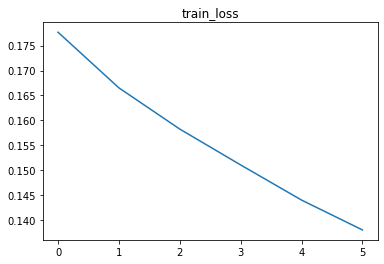

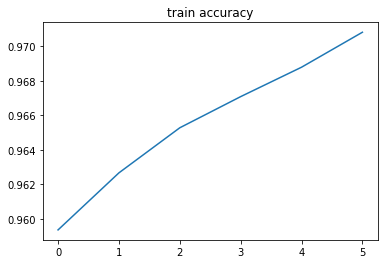

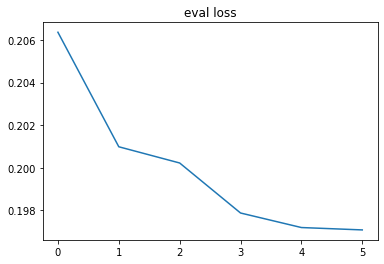

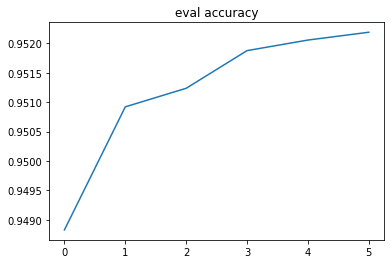

In [17]:
train(net,train_data,test_data,6,optimer,scheduler,loss_function,0)#由于条件和时间有限，只训练了11轮；
#前面训练了五轮，但是中间中断了内核，修改了train函数，之后右训练了6轮；完整训练过程见日志；

In [18]:
torch.save(net,"chinese_classification.pth")#保存模型；